In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

In [2]:
import os, shutil, copy, ntpath, datetime, zipfile
import keras
from keras import models, layers, callbacks
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf

import matplotlib.pyplot as plt

import boto3
import glob
import ntpath
import re

import numpy as np
import pandas as pd

Using TensorFlow backend.


In [16]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#### Settings
IMAGE_SHAPE=(200, 200, 3)

LIMIT_BATCHES = 30
#LIMIT_BATCHES = None

NUM_EPOCHS = 30
BATCH_SIZE = 20
NUM_CLASSES = 29

# PRETRAIN_MODEL = 'conv_base_local'
# PRETRAIN_MODEL = 'conv_base_vgg16'
PRETRAIN_MODEL = None

In [0]:
import os

#### FilePath Information
DATA_DIR = '/content/gdrive/My Drive/'
#ASL_ALPHABET_DATASET_ZIP = os.path.join(DATA_DIR, 'asl_alphabet_train2.zip')
#LOCAL_DATASET_ZIP = '/tmp/asl_alphabet_train2.zip'
#LOCAL_DATASET = '/tmp/asl_alphabet_train2'


#ASL_ALPHABET_TEST_DATASET_ZIP = os.path.join(DATA_DIR, 'asl_alphabet_test2.zip')
#LOCAL_TEST_DATASET_ZIP = '/tmp/asl_alphabet_test2.zip'
#LOCAL_TEST_DATASET = '/tmp/asl_alphabet_test2'


#SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet')

ASL_ALPHABET_DATASET_ZIP = os.path.join(DATA_DIR, 'asl_alphabet_train1.zip')
LOCAL_DATASET_ZIP = '/tmp/asl_alphabet_train1.zip'
LOCAL_DATASET = '/tmp/asl_alphabet_train1'


ASL_ALPHABET_TEST_DATASET_ZIP = os.path.join(DATA_DIR, 'handsigns.zip')
LOCAL_TEST_DATASET_ZIP = '/tmp/handsigns.zip'
LOCAL_TEST_DATASET = '/tmp/handsigns'


SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_handsigns')

In [0]:
if not os.path.isfile(LOCAL_DATASET_ZIP):
  %time shutil.copy(ASL_ALPHABET_DATASET_ZIP, LOCAL_DATASET_ZIP)

In [0]:
if not os.path.isfile(LOCAL_TEST_DATASET_ZIP):
  %time shutil.copy(ASL_ALPHABET_TEST_DATASET_ZIP, LOCAL_TEST_DATASET_ZIP)

In [21]:
if not os.path.isdir(LOCAL_DATASET):
  with zipfile.ZipFile(LOCAL_DATASET_ZIP, 'r') as zip_ref:
      %time zip_ref.extractall('/tmp')
   
if not os.path.isdir(LOCAL_TEST_DATASET):
  with zipfile.ZipFile(LOCAL_TEST_DATASET_ZIP, 'r') as zip_ref:
      %time zip_ref.extractall('/tmp')


CPU times: user 5.31 s, sys: 2.56 s, total: 7.87 s
Wall time: 8.38 s


In [0]:
# dataset definition with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# end with augmentation
LOCAL_TEST1_DATASET = '/tmp/asl_alphabet_test1'
LOCAL_AHE_TEST_DATASET = '/tmp/ahe_asl_test1a'
LOCAL_AHE_NEG_TEST_DATASET = '/tmp/ahe_neg_asl_test1n'
LOCAL_FC_AHE_TEST_DATASET = '/tmp/fc_ahe_asl_test1'
LOCAL_FC_AHE_NEG_TEST_DATASET = '/tmp/fc_ahe_neg_asl_test1'






In [30]:


#create generators
train_generator = train_datagen.flow_from_directory(
           LOCAL_DATASET,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           color_mode = "rgb",
           subset='training'
)

#create generators

validation_generator = train_datagen.flow_from_directory(
           LOCAL_DATASET,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           color_mode = "rgb",
           subset='validation'
)

test1_generator = test_datagen.flow_from_directory(
         LOCAL_TEST1_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)

ahe_test_generator = test_datagen.flow_from_directory(
         LOCAL_AHE_TEST_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)
ahe_neg_test_generator = test_datagen.flow_from_directory(
         LOCAL_AHE_NEG_TEST_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)
fc_ahe_test_generator = test_datagen.flow_from_directory(
         LOCAL_FC_AHE_TEST_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)
fc_ahe_neg_test_generator = test_datagen.flow_from_directory(
         LOCAL_FC_AHE_NEG_TEST_DATASET,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
)



Found 371114 images belonging to 29 classes.
Found 41221 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.
Found 4239 images belonging to 29 classes.


In [24]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [25]:
# uaing augmentation to eliminate overfitting

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(29, activation='sigmoid'))

optimizer = keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_4 (Dense)              (None, 29)                7453      
Total params: 19,440,989
Trainable params: 19,440,989
Non-trainable params: 0
_________________________________________________________________


In [31]:


# must freeze the pre-trained convnet layers before running the model 
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4
This is the number of trainable weights after freezing the conv base: 4


In [0]:
optimizer = keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
steps_per_epoch = None

if LIMIT_BATCHES is None: 
  steps_per_epoch_train = len(train_generator) 
  steps_per_epoch_val = len(validation_generator) 

else: 
  steps_per_epoch_train = len(train_generator)/(BATCH_SIZE) 
  steps_per_epoch_val = len(validation_generator)/BATCH_SIZE

callbacks_list = [ callbacks.EarlyStopping(monitor='acc', patience=5), 
                  callbacks.ModelCheckpoint(filepath = 'handsigns.h5', 
                  monitor = 'val_loss', 
                  save_best_only = True), 
                  callbacks.ReduceLROnPlateau(monitor='val_loss', 
                  factor = 0.1, 
                  patience=10) ]


history = model.fit_generator(train_generator,
                    epochs=NUM_EPOCHS,
                    callbacks = callbacks_list,
                    verbose = 1,
                    steps_per_epoch = steps_per_epoch_train,
                    validation_steps = steps_per_epoch_val,
                    validation_data=validation_generator)

Epoch 1/30
928/927 [==============================] - 311s 335ms/step - loss: 2.2495 - acc: 0.3834 - val_loss: 1.8568 - val_acc: 0.4644
Epoch 2/30
928/927 [==============================] - 306s 330ms/step - loss: 1.2785 - acc: 0.6379 - val_loss: 1.4066 - val_acc: 0.5933
Epoch 3/30
928/927 [==============================] - 304s 328ms/step - loss: 1.0078 - acc: 0.7068 - val_loss: 1.1602 - val_acc: 0.6529
Epoch 4/30
928/927 [==============================] - 302s 326ms/step - loss: 0.8624 - acc: 0.7435 - val_loss: 1.1878 - val_acc: 0.6442
Epoch 5/30
928/927 [==============================] - 301s 324ms/step - loss: 0.7634 - acc: 0.7720 - val_loss: 1.0920 - val_acc: 0.6582
Epoch 6/30
928/927 [==============================] - 299s 323ms/step - loss: 0.7053 - acc: 0.7831 - val_loss: 1.1184 - val_acc: 0.6817
Epoch 7/30
928/927 [==============================] - 299s 323ms/step - loss: 0.6545 - acc: 0.8014 - val_loss: 1.0134 - val_acc: 0.6865
Epoch 8/30
928/927 [============================

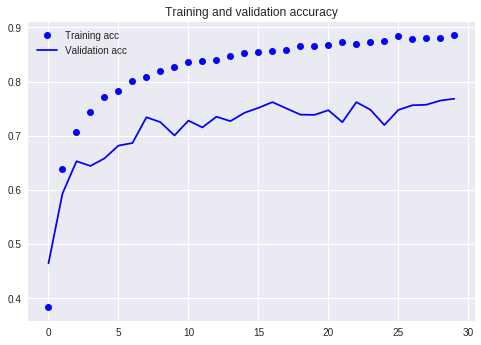

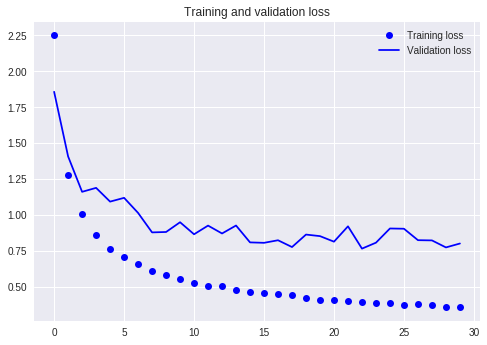

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
test_loss, test_acc = model.evaluate_generator(test1_generator,steps=len(test1_generator)/BATCH_SIZE)
print('test1_acc: ',test_acc)
test_loss, test_acc = model.evaluate_generator(ahe_test_generator,len(ahe_test_generator)/BATCH_SIZE)
print('ahe_test_acc: ',test_acc)
test_loss, test_acc = model.evaluate_generator(ahe_neg_test_generator,len(ahe_neg_test_generator)/BATCH_SIZE)
print('ahe__neg_test_acc: ',test_acc)

test_loss, test_acc = model.evaluate_generator(fc_ahe_test_generator,len(fc_ahe_test_generator)/BATCH_SIZE)
print('fc_ahe_test_acc: ',test_acc)
test_loss, test_acc = model.evaluate_generator(fc_ahe_neg_test_generator,len(fc_ahe_neg_test_generator)/BATCH_SIZE)
print('fc_ahe__neg_test_acc: ',test_acc)

test1_acc:  0.922727265141227
ahe_test_acc:  0.9681818105957725
ahe__neg_test_acc:  0.9363636320287531
fc_ahe_test_acc:  0.9545454491268505
fc_ahe__neg_test_acc:  0.9272727207704023
